# t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# 2) Load MNIST (try Keras; fallback to sklearn digits)
try:
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    X = np.concatenate([x_train, x_test], axis=0)   # shape (70000, 28, 28)
    y = np.concatenate([y_train, y_test], axis=0)
    X = X.reshape((X.shape[0], -1)).astype(np.float32)  # flatten to (n_samples, 784)
    print("Loaded MNIST:", X.shape)
    is_mnist = True
except Exception as e:
    from sklearn.datasets import load_digits
    digits = load_digits()
    X = digits.data.astype(np.float32)
    y = digits.target
    print("Fallback to sklearn digits:", X.shape)
    is_mnist = False

Fallback to sklearn digits: (1797, 64)


In [3]:
# 3) Basic scaling / normalization
# If MNIST, pixel range is 0-255; rescale to [0,1] then standardize.
if is_mnist:
    X = X / 255.0

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # zero-mean, unit-variance
print("Scaled shape:", X_scaled.shape)

Scaled shape: (1797, 64)


In [4]:
# 4) Subsample to make t-SNE feasible in a reasonable time
# Choose n_samples ~ 2000-10000 depending on compute. Default: 5000
n_samples = 5000
rng = np.random.RandomState(42)
if X_scaled.shape[0] > n_samples:
    idx = rng.choice(X_scaled.shape[0], n_samples, replace=False)
    X_sub = X_scaled[idx]
    y_sub = y[idx]
else:
    X_sub = X_scaled
    y_sub = y
print("Using subset:", X_sub.shape)

Using subset: (1797, 64)


In [5]:
# 5) PCA preprocessing 
pca_components = 50   # reduce to 50 dims before t-SNE (typical)
print("Running PCA -> {} components ...".format(pca_components))
t0 = time.time()
pca = PCA(n_components=pca_components, random_state=42)
X_pca = pca.fit_transform(X_sub)
print("PCA done (time {:.1f}s). Explained variance (top {}): {:.3f}".format(
    time.time()-t0, pca_components, np.sum(pca.explained_variance_ratio_)))

Running PCA -> 50 components ...
PCA done (time 0.1s). Explained variance (top 50): 0.983


In [6]:
# 6) Run t-SNE (2D)
tsne_params = {
    "n_components": 2,
    "perplexity": 30,      # try 5..50
    "learning_rate": 200,  # typical: 50..1000 (200 is a good start)
    "n_iter": 1000,        # increase to 2000+ for better convergence
    "init": "pca",         # often faster + more stable than 'random'
    "random_state": 42,
    # "method": "barnes_hut" # sklearn chooses appropriate method
}

In [7]:
print("Running t-SNE with params:", tsne_params)
t0 = time.time()
tsne = TSNE(**tsne_params)
X_tsne = tsne.fit_transform(X_pca)   # shape (n_samples, 2)
print("t-SNE finished in {:.1f}s".format(time.time() - t0))

Running t-SNE with params: {'n_components': 2, 'perplexity': 30, 'learning_rate': 200, 'n_iter': 1000, 'init': 'pca', 'random_state': 42}


c:\Users\Rajnish\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished in 13.8s


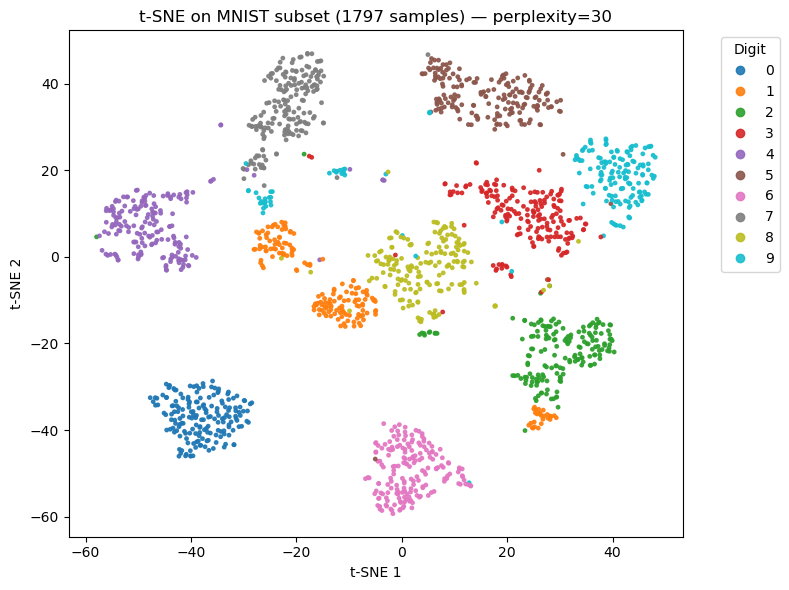

In [10]:
# 7) Basic 2D scatter plot colored by digit
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, cmap='tab10', s=6, alpha=0.9)
plt.title(f"t-SNE on MNIST subset ({X_tsne.shape[0]} samples) — perplexity={tsne_params['perplexity']}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
# Create legend with digits 0..9
handles, _ = scatter.legend_elements(num=10)
plt.legend(handles, [str(i) for i in range(10)], title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

c:\Users\Rajnish\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Rajnish\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Rajnish\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


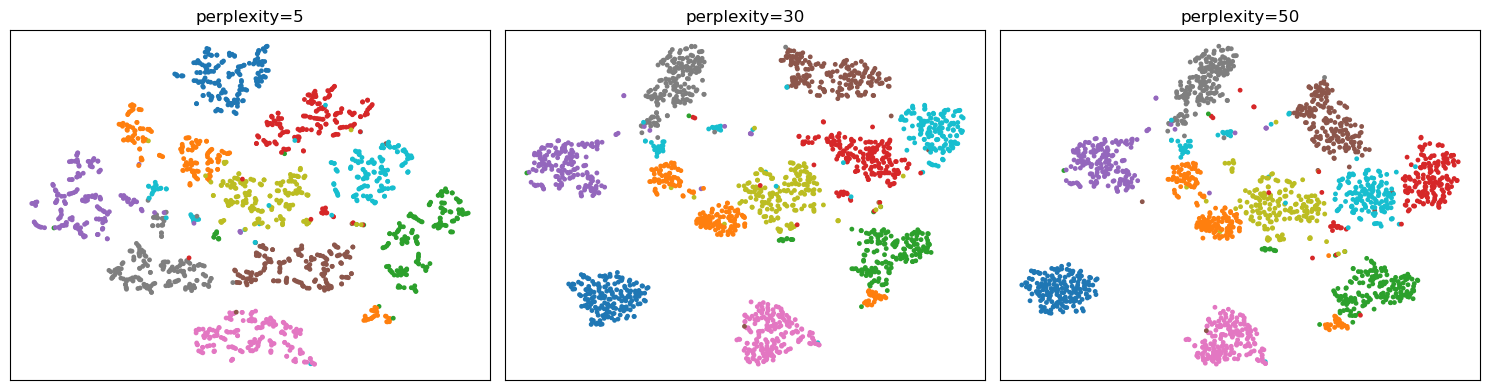

In [11]:
# 8) compare different perplexities (slow: runs multiple t-SNEs)
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, len(perplexities), figsize=(5*len(perplexities),4))
for ax, perp in zip(axes, perplexities):
    params = tsne_params.copy()
    params['perplexity'] = perp
    params['init'] = 'pca'
    tsne_local = TSNE(**params)
    X_t = tsne_local.fit_transform(X_pca)
    ax.scatter(X_t[:,0], X_t[:,1], c=y_sub, cmap='tab10', s=6)
    ax.set_title(f"perplexity={perp}")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

In [12]:
# 9) Save embeddings for later visualization
import os
os.makedirs("embeddings", exist_ok=True)
np.save("embeddings/mnist_tsne_{}_samples.npy".format(X_tsne.shape[0]), X_tsne)
np.save("embeddings/mnist_labels_{}_samples.npy".format(X_tsne.shape[0]), y_sub)
print("Saved embeddings/labels to ./embeddings/")

Saved embeddings/labels to ./embeddings/


---

## t-SNE on Iris Dataset

In [16]:
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
# Set Seaborn style for a nicer look
sns.set(style="whitegrid", context="notebook")

In [18]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
colors = sns.color_palette("viridis", len(target_names))  # Color palette for classes

In [19]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

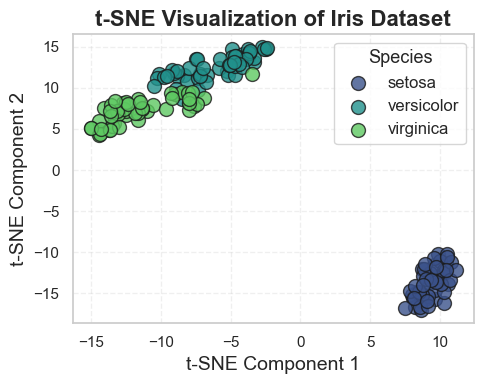

In [22]:
plt.figure(figsize=(5, 4))

# Plot each class separately for nicer control over markers and colors
for i, target_name in enumerate(target_names):
    plt.scatter(
        X_tsne[y == i, 0], X_tsne[y == i, 1],
        label=target_name,
        s=100,  # marker size
        alpha=0.8,  # transparency
        edgecolors='k',  # black edge for markers
        c=[colors[i]]  # color for this class
    )

# Titles and labels
plt.title("t-SNE Visualization of Iris Dataset", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=14)
plt.ylabel("t-SNE Component 2", fontsize=14)

# Add grid
plt.grid(True, linestyle='--', alpha=0.3)

# Add legend
plt.legend(title="Species", fontsize=12, title_fontsize=13, loc='best')

# Show plot
plt.tight_layout()
plt.show()